In [10]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import csv
import pandas as pd

In [11]:
# This is the data to load
def load(file_name):
    moves = []
    with open(file_name, newline='') as csv_file:
        reader = csv.reader(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
        next(reader, None)
        for row in reader:
            moves.append(row)
    return moves

In [12]:
def edit(file_name):
    moves = []
    special_types = ['Fire', 'Water', 'Electric', 'Grass', 'Ice', 'Psychic', 'Dragon']
    with open(file_name, newline='') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['Power'] != '—':
                if row['Type'] in special_types:
                    row['Cat.'] = 'Special'
                else:
                    row['Cat.'] = 'Physical'
            else:
                if row['Name'] == 'Dragon Rage' or row['Name'] == 'Sonic Boom':
                    row['Cat.'] = 'Fixed'
                else:
                    row['Cat.'] = 'Status'
            moves.append(row)
        
    with open('moves.csv', 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=list(moves[0].keys()), delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
        writer.writeheader()
        
        for row in moves:
            writer.writerow(row)

#edit('./new_moves.csv')

In [13]:
# One hot encode the type of each move
def move_type(move_data, vec_move_data):
    types = ['Normal', 'Fighting', 'Flying', 'Poison', 'Ground', 'Rock', 'Bug', 'Ghost', 'Fire', 'Water', 'Grass',
            'Electric', 'Psychic', 'Ice', 'Dragon']
   
    type_num = 0
    type_row = 0
    
    for move_type in types:
        vec_move_data[:, type_row, type_num] = np.where(move_data[:, 0] == move_type, 1, 0)
        type_num += 1
        
# One hot encode the category of each move
def move_category(move_data, vec_move_data):    
    categories = ['Physical', 'Special', 'Status', 'Fixed']
    cat_num = 0
    cat_row = 1
    for cat in categories:
        vec_move_data[:, cat_row, cat_num] = np.where(move_data[:, 1] == cat, 1, 0)
        cat_num += 1
    
    type_row = 0
    status_cat = 2
    print(vec_move_data[:, type_row].shape)
    print(vec_move_data[:,])
    #vec_move_data[:, type_row] = np.where(vec_move_data[:, cat_row, status_cat] == 1, np.zeros((1, 22)),\
                                          #vec_move_data[:, type_row])
        
# Vectorize and normalize the power, accuracy, and pp of each move
def pow_acc_pp(move_data, vec_move_data):
    # Make each move have a normalized power, accuracy, and pp
    # [[...],[norm_pow, norm_acc , norm_pp, ...],[...],[...]]
    # Power, accuracy, and pp are stored in the 2nd, 3rd, and 4th columns of move_data
    categories = [2, 3, 4]

    # Account for infinite accuracy moves (ie. swift)
    move_data[:, 3] = np.where(move_data[:, 3] == '∞', 110, move_data[:, 3])
    pow_acc_pp_row = 2
    # Set row to all ones so vector multiplication works
    vec_move_data[:, pow_acc_pp_row] = np.zeros((1, 22))

    for i in range(len(categories)):
        # Impute undefined values
        vec_move_data[:, pow_acc_pp_row, i] = np.where(move_data[:, categories[i]] == '—', 0, move_data[:, categories[i]])
        # Normalize Data
        vec_move_data[:, pow_acc_pp_row, i] /= np.max(vec_move_data[:, pow_acc_pp_row, i])
        if i == 0:
            vec_move_data[:, pow_acc_pp_row, i] *=4

# Opponent effect vector - vector containing info about move effects on opponents
# Full of painful if statements :(
def opponent_effects(move_data, vec_move_data):
    categories = ['attack', 'defense', 'special', 'evasive', 'speed', 'accuracy', 'confus', 'poison', 'flinch', 
                 'freez', 'burn', 'paralyz', 'sleep']
    opp_eff_row = 3
    # Make the description string lower case
    move_data[:, 5] = np.char.lower(move_data[:, 5].astype('str'))
    move_desc_col = 5
    debuff_cats = ['attack', 'defense', 'special', 'evasive', 'speed', 'accuracy']
    status_cats = ['confus', 'poison', 'flinch', 'freez', 'burn', 'paralyz', 'sleep']
    
    
    for i in range(len(categories)):
        cat = categories[i]
        # Check whether the description contains the given category
        contains_cat = np.char.find(move_data[:, 5].astype('str'), cat)
        contains_cat = np.where(contains_cat[:] == -1, False, True)
        # Checks whether the effect is on the opponent or not
        contains_opp = np.char.find(move_data[:, 5].astype('str'), 'opponent')
        contains_opp = np.where(contains_opp[:] == -1, False, True)
        cat_and_opp = np.logical_and.reduce([contains_cat, contains_opp])
        # Set "degree" of each category (ie., sharply lowers attack vs lowers attack)
        
        if cat in debuff_cats or cat in status_cats:
            #print(cat)
            #print(cat_and_opp)
            #print(move_data[1, 5])
            vec_move_data[:, opp_eff_row, i] = np.where(cat_and_opp[:], 0.75, 0)
            #print(vec_move_data[1, opp_eff_row])
            sharp = np.char.find(move_data[:, 5].astype('str'), 'sharp')
            sharp = np.where(sharp[:] == -1, False, True)
            sharp_cat_opp = np.logical_and.reduce([cat_and_opp, sharp])
            #print(sharp_cat_opp)
            vec_move_data[:, opp_eff_row, i] = np.where(sharp_cat_opp[:], 1, vec_move_data[:, opp_eff_row, i])

# User effect vector - vector containing info about move effects on opponents
# Full of painful if statements :(
def user_effects(move_data, vec_move_data):
    categories = ['attack', 'defense', 'special', 'evasive', 'speed', 'accuracy', 'confus', 'poison', 'flinch', 
                 'freez', 'burn', 'paralyz', 'sleep']
    user_eff_row = 4
    # Make the description string lower case
    move_data[:, 5] = np.char.lower(move_data[:, 5].astype('str'))
    move_desc_col = 5
    buff_cats = ['attack', 'defense', 'special', 'evasive', 'speed', 'accuracy']
    status_cats = ['confus', 'poison', 'flinch', 'freez', 'burn', 'paralyz', 'sleep']

    
    for i in range(len(categories)):
        cat = categories[i]
        # Check whether the description contains the given category
        contains_cat = np.char.find(move_data[:, 5].astype('str'), cat)
        contains_cat = np.where(contains_cat[:] == -1, False, True)
        # Checks whether the effect is on the opponent or not
        contains_user = np.char.find(move_data[:, 5].astype('str'), 'user')
        contains_user = np.where(contains_user[:] == -1, False, True)
        cat_and_user = np.logical_and.reduce([contains_cat, contains_user])
        # Set "degree" of each category (ie., sharply lowers attack vs lowers attack)
        
        if cat in buff_cats or cat in status_cats:
            vec_move_data[:, user_eff_row, i] = np.where(cat_and_user[:], 0.75, 0)
            #print(vec_move_data[1, opp_eff_row])
            sharp = np.char.find(move_data[:, 5].astype('str'), 'sharp')
            sharp = np.where(sharp[:] == -1, False, True)
            sharp_cat_user = np.logical_and.reduce([cat_and_user, sharp])
            #print(sharp_cat_opp)
            vec_move_data[:, user_eff_row, i] = np.where(sharp_cat_user[:], 1, vec_move_data[:, user_eff_row, i])
    
def vectorize_moves(moves):
    moves = load('new_moves.csv')
    move_df = pd.DataFrame(moves)
    # Store the move names in an np array
    move_names = move_df.iloc[:, 0].to_numpy()
    # Store the move data in another np array
    move_data = move_df.drop(0, 1).to_numpy()
    vec_move_data = np.zeros((len(move_data[:]), 5, 22))
    move_type(move_data, vec_move_data)
    move_category(move_data, vec_move_data)
    pow_acc_pp(move_data, vec_move_data)
    opponent_effects(move_data, vec_move_data)
    user_effects(move_data, vec_move_data)
    return (move_names, vec_move_data)

moves = load('moves.csv')

names, data = vectorize_moves(moves)
#print(data[5, :, :])

(165, 22)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [14]:
# Autoencoder to compress moves to a vector of reasonable size
class AE(nn.Module):
    def __init__(self, input_size=110, h_dim=70, h2_dim=10, lr=1e-3):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(input_size, h_dim).double()
        self.fc2 = nn.Linear(h_dim, h2_dim).double()
        self.fc3 = nn.Linear(h2_dim, h_dim).double()
        self.out = nn.Linear(h_dim, input_size).double()
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
    
    def encode(self, x):
        res = F.relu(self.fc1(x))
        return self.fc2(res)
    
    def decode(self, x):
        res = F.relu(self.fc3(x))
        return self.out(res)
    
    def forward(self, x):
        encoding = self.encode(x)
        x_reconst = self.decode(encoding)
        return x_reconst
    
    def train(self, x):
        loss = nn.MSELoss()
        output = self.forward(x)
        output = loss(x, output)
        output.backward()
        self.opt.step()
        self.opt.zero_grad()
        return loss
        

In [15]:
# Training Data - Acid Armor, Barrier, Absorb
res = []
"""
# Absorb
res.append(data[0, :, :])
print(names[0])
# Acid Armor
res.append(data[2, :, :])
print(names[2])
print(data[2, :, :])
#Agility
res.append(data[3, :, :])
print(names[3])
#Amnesia
#res.append(data[4, :, :])
# Barrier
res.append(data[7, :, :])
print(data[7, :, :])
print(names[7])
# Bubble and bubble beam
res.append(data[15, :, :])
print(names[15])
res.append(data[16, :, :])

print(names[16])
#Surf
res.append(data[140, :, :])
print(names[140])
# Water Gun
res.append(data[159, :, :])
print(names[159])
# Vine Whip
res.append(data[158, :, :])
print(names[158])

# Mega drain
res.append(data[79, :, :])
print(names[79])
# Thunder, Thundershock, and Thunderbolt
res.append([data[148, :, :]])
print(names[148])
res.append([data[150, :, :]])
print(names[150])
res.append([data[152, :, :]])
print(names[152])
"""

#print((data[2, :, :] == data[7, :, :]).all())
# Now, res contains [Acid Armor, Barrier, Absorb]
# Acid Armor and Barrier are the same move, so the autoencoder should learn the same encoding for both
# The encoding for absorb, an attacking and non-buffing move, should be completely different

for i in range(len(data)):
    res.append(data[i, :, :])

In [16]:
num_epochs = 1000
model = AE()
for epoch in range(num_epochs):
    print('Epoch', epoch, '...')
    for x in res:
        x_tensor = torch.flatten(torch.tensor(x))
        x_tensor.shape
        model.train(x_tensor)

Epoch 0 ...
Epoch 1 ...
Epoch 2 ...
Epoch 3 ...
Epoch 4 ...
Epoch 5 ...
Epoch 6 ...
Epoch 7 ...
Epoch 8 ...
Epoch 9 ...
Epoch 10 ...
Epoch 11 ...
Epoch 12 ...
Epoch 13 ...
Epoch 14 ...
Epoch 15 ...
Epoch 16 ...
Epoch 17 ...
Epoch 18 ...
Epoch 19 ...
Epoch 20 ...
Epoch 21 ...
Epoch 22 ...
Epoch 23 ...
Epoch 24 ...
Epoch 25 ...
Epoch 26 ...
Epoch 27 ...
Epoch 28 ...
Epoch 29 ...
Epoch 30 ...
Epoch 31 ...
Epoch 32 ...
Epoch 33 ...
Epoch 34 ...
Epoch 35 ...
Epoch 36 ...
Epoch 37 ...
Epoch 38 ...
Epoch 39 ...
Epoch 40 ...
Epoch 41 ...
Epoch 42 ...
Epoch 43 ...
Epoch 44 ...
Epoch 45 ...
Epoch 46 ...
Epoch 47 ...
Epoch 48 ...
Epoch 49 ...
Epoch 50 ...
Epoch 51 ...
Epoch 52 ...
Epoch 53 ...
Epoch 54 ...
Epoch 55 ...
Epoch 56 ...
Epoch 57 ...
Epoch 58 ...
Epoch 59 ...
Epoch 60 ...
Epoch 61 ...
Epoch 62 ...
Epoch 63 ...
Epoch 64 ...
Epoch 65 ...
Epoch 66 ...
Epoch 67 ...
Epoch 68 ...
Epoch 69 ...
Epoch 70 ...
Epoch 71 ...
Epoch 72 ...
Epoch 73 ...
Epoch 74 ...
Epoch 75 ...
Epoch 76 ...
Epoch 77 

Epoch 594 ...
Epoch 595 ...
Epoch 596 ...
Epoch 597 ...
Epoch 598 ...
Epoch 599 ...
Epoch 600 ...
Epoch 601 ...
Epoch 602 ...
Epoch 603 ...
Epoch 604 ...
Epoch 605 ...
Epoch 606 ...
Epoch 607 ...
Epoch 608 ...
Epoch 609 ...
Epoch 610 ...
Epoch 611 ...
Epoch 612 ...
Epoch 613 ...
Epoch 614 ...
Epoch 615 ...
Epoch 616 ...
Epoch 617 ...
Epoch 618 ...
Epoch 619 ...
Epoch 620 ...
Epoch 621 ...
Epoch 622 ...
Epoch 623 ...
Epoch 624 ...
Epoch 625 ...
Epoch 626 ...
Epoch 627 ...
Epoch 628 ...
Epoch 629 ...
Epoch 630 ...
Epoch 631 ...
Epoch 632 ...
Epoch 633 ...
Epoch 634 ...
Epoch 635 ...
Epoch 636 ...
Epoch 637 ...
Epoch 638 ...
Epoch 639 ...
Epoch 640 ...
Epoch 641 ...
Epoch 642 ...
Epoch 643 ...
Epoch 644 ...
Epoch 645 ...
Epoch 646 ...
Epoch 647 ...
Epoch 648 ...
Epoch 649 ...
Epoch 650 ...
Epoch 651 ...
Epoch 652 ...
Epoch 653 ...
Epoch 654 ...
Epoch 655 ...
Epoch 656 ...
Epoch 657 ...
Epoch 658 ...
Epoch 659 ...
Epoch 660 ...
Epoch 661 ...
Epoch 662 ...
Epoch 663 ...
Epoch 664 ...
Epoch 

In [54]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
seed = 10
new_res = []
types = ['Normal', 'Fighting', 'Flying', 'Poison', 'Ground', 'Rock', 'Bug', 'Ghost', 'Fire', 'Water', 'Grass',\
         'Electric', 'Psychic', 'Ice', 'Dragon']

move_num = 0
for item in res:
    new_res.append(model.encode(torch.flatten(torch.tensor(item))).detach().numpy())
    # Color each move by its type

new_res = np.array(new_res)
similarities = euclidean_distances(new_res)
print(similarities)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

[[0.         1.16590583 1.05583249 ... 1.29934869 1.12073431 0.761607  ]
 [1.16590583 0.         1.18722273 ... 1.05247452 1.18243927 1.09012763]
 [1.05583249 1.18722273 0.         ... 1.32684771 0.86050029 1.16739122]
 ...
 [1.29934869 1.05247452 1.32684771 ... 0.         1.01926551 1.05435121]
 [1.12073431 1.18243927 0.86050029 ... 1.01926551 0.         1.07692035]
 [0.761607   1.09012763 1.16739122 ... 1.05435121 1.07692035 0.        ]]


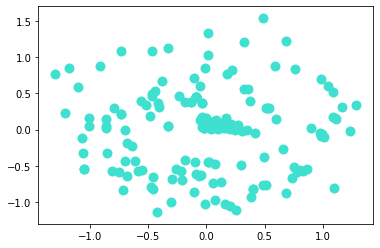

In [55]:
import matplotlib.pyplot as plt
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=100, lw=0, label='MDS')

In [165]:
pokemon = load('pokemon.csv')

def poke_type(vec_poke_data, poke_data):
    types = ['Normal', 'Fighting', 'Flying', 'Poison', 'Ground', 'Rock', 'Bug', 'Ghost', 'Fire', 'Water', 'Grass',
            'Electric', 'Psychic', 'Ice', 'Dragon']
       
    type_num = 0
    type_row = 0
    poke_data = poke_data.astype('str')
    poke_num = 0
    for poke in poke_data:
        type_num = 0
        for poke_type in types:
            if poke_type in poke[0]:
                vec_poke_data[poke_num, type_row, type_num] = 1
            type_num += 1
        poke_num += 1

def poke_stats(vec_poke_data, poke_data):
    poke_data = np.array(poke_data)
    stats_row = 1
    print(poke_data)
    vec_poke_data[:, stats_row, 0:6] = poke_data[:, 1:]
    # Normalize every value
    for i in range(6):
        vec_poke_data[:, stats_row, i] /= np.max(vec_poke_data[:, stats_row, i])

            
def vectorize_pokemon(pokemon):
    poke_df = pd.DataFrame(pokemon)
    # Store the move names in an np array
    poke_names = poke_df.iloc[:, 0:2].to_numpy()
    # Store the move data in another np array
    poke_data = poke_df.drop([0, 1], 1).to_numpy()
    
    vec_poke_data = np.zeros((len(pokemon),2, 15))
    
    poke_type(vec_poke_data, poke_data)
    poke_stats(vec_poke_data, poke_data)
    return poke_names, vec_poke_data
    

In [183]:
poke_names, vec_poke_data = vectorize_pokemon(pokemon)

[["['Grass', 'Poison']" '253' '45' ... '49' '65' '45']
 ["['Grass', 'Poison']" '325' '60' ... '63' '80' '60']
 ["['Grass', 'Poison']" '425' '80' ... '83' '100' '80']
 ...
 ["['Dragon', 'Flying']" '500' '91' ... '95' '100' '80']
 ["['Psychic']" '590' '106' ... '90' '154' '130']
 ["['Psychic']" '500' '100' ... '100' '100' '100']]


In [184]:
move_embedder = model

poke_data = []
for i in range(len(poke_names)):
    poke_data.append(vec_poke_data[i])

In [212]:
# Train pokembeddings
num_epochs = 500
poke_embedder = AE(input_size=30, h_dim=15, h2_dim=10)
for epoch in range(num_epochs):
    print('Epoch', epoch, '...')
    for x in poke_data:
        x_tensor = torch.flatten(torch.tensor(x))
        poke_embedder.train(x_tensor)

Epoch 0 ...
Epoch 1 ...
Epoch 2 ...
Epoch 3 ...
Epoch 4 ...
Epoch 5 ...
Epoch 6 ...
Epoch 7 ...
Epoch 8 ...
Epoch 9 ...
Epoch 10 ...
Epoch 11 ...
Epoch 12 ...
Epoch 13 ...
Epoch 14 ...
Epoch 15 ...
Epoch 16 ...
Epoch 17 ...
Epoch 18 ...
Epoch 19 ...
Epoch 20 ...
Epoch 21 ...
Epoch 22 ...
Epoch 23 ...
Epoch 24 ...
Epoch 25 ...
Epoch 26 ...
Epoch 27 ...
Epoch 28 ...
Epoch 29 ...
Epoch 30 ...
Epoch 31 ...
Epoch 32 ...
Epoch 33 ...
Epoch 34 ...
Epoch 35 ...
Epoch 36 ...
Epoch 37 ...
Epoch 38 ...
Epoch 39 ...
Epoch 40 ...
Epoch 41 ...
Epoch 42 ...
Epoch 43 ...
Epoch 44 ...
Epoch 45 ...
Epoch 46 ...
Epoch 47 ...
Epoch 48 ...
Epoch 49 ...
Epoch 50 ...
Epoch 51 ...
Epoch 52 ...
Epoch 53 ...
Epoch 54 ...
Epoch 55 ...
Epoch 56 ...
Epoch 57 ...
Epoch 58 ...
Epoch 59 ...
Epoch 60 ...
Epoch 61 ...
Epoch 62 ...
Epoch 63 ...
Epoch 64 ...
Epoch 65 ...
Epoch 66 ...
Epoch 67 ...
Epoch 68 ...
Epoch 69 ...
Epoch 70 ...
Epoch 71 ...
Epoch 72 ...
Epoch 73 ...
Epoch 74 ...
Epoch 75 ...
Epoch 76 ...
Epoch 77 

In [213]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
seed = 10
new_poke_data = []
types = ['Normal', 'Fighting', 'Flying', 'Poison', 'Ground', 'Rock', 'Bug', 'Ghost', 'Fire', 'Water', 'Grass',\
         'Electric', 'Psychic', 'Ice', 'Dragon']

for item in poke_data:
    new_poke_data.append(poke_embedder.encode(torch.flatten(torch.tensor(item))).detach().numpy())

new_poke_data = np.array(new_poke_data)
poke_sim = euclidean_distances(new_poke_data)
print(poke_sim)

poke_mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
poke_pos = poke_mds.fit(poke_sim).embedding_

[[0.         0.20338577 0.4870001  ... 2.11304428 2.21510462 2.06480238]
 [0.20338577 0.         0.28369398 ... 2.10050383 2.13602545 2.01178455]
 [0.4870001  0.28369398 0.         ... 2.11495739 2.05841791 1.97404253]
 ...
 [2.11304428 2.10050383 2.11495739 ... 0.         2.11721377 1.98644034]
 [2.21510462 2.13602545 2.05841791 ... 2.11721377 0.         0.35891283]
 [2.06480238 2.01178455 1.97404253 ... 1.98644034 0.35891283 0.        ]]


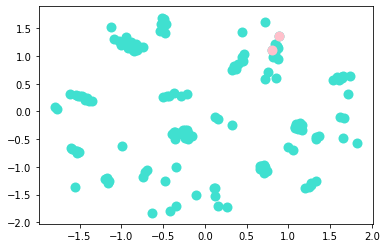

In [221]:
import matplotlib.pyplot as plt
# Plot of the pokemon emeddings
plt.scatter(poke_pos[:, 0], poke_pos[:, 1], color='turquoise', s=100, lw=0, label='MDS')

In [264]:
move_names = names
with open('updated_movembeddings.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    move_num = 0
    for row in new_res:
        move_name = np.array([move_names[move_num]])
        row = np.concatenate((move_name, row), axis=0)
        writer.writerow(row)
        move_num += 1

"""
with open('pokembeddings.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    poke_num = 0
    for row in new_poke_data:
        poke_name = np.array([poke_names[poke_num, 1]])
        row = np.concatenate((poke_name, row), axis=0)
        writer.writerow(row)
        poke_num += 1"""